Import Libraries

In this section we import the libraries that will be required to process the data.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Libraries imported.


Download and Explore Dataset

Download and Explore Dataset Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a wget command and access the data. So let's go ahead and do that.

In [2]:
！wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


Tranform the data into a pandas dataframe

In [3]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                         'Neighborhood': neighborhood_name,
                                         'Latitude': neighborhood_lat,
                                         'Longitude': neighborhood_lon}, ignore_index=True)


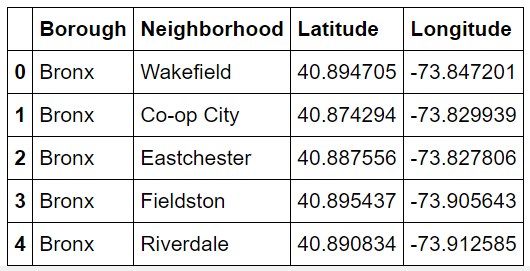

In [6]:
neighborhoods.head()

Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7308619, -73.9871558.



Create a map of New York with neighborhoods superimposed on top.

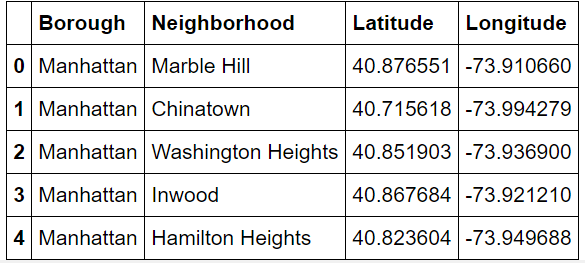

In [10]:

manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

In [ ]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Foursquare venues

In [12]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
                response = requests.get(url).json()
                results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [13]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5'
CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR'
VERSION = '20181020'

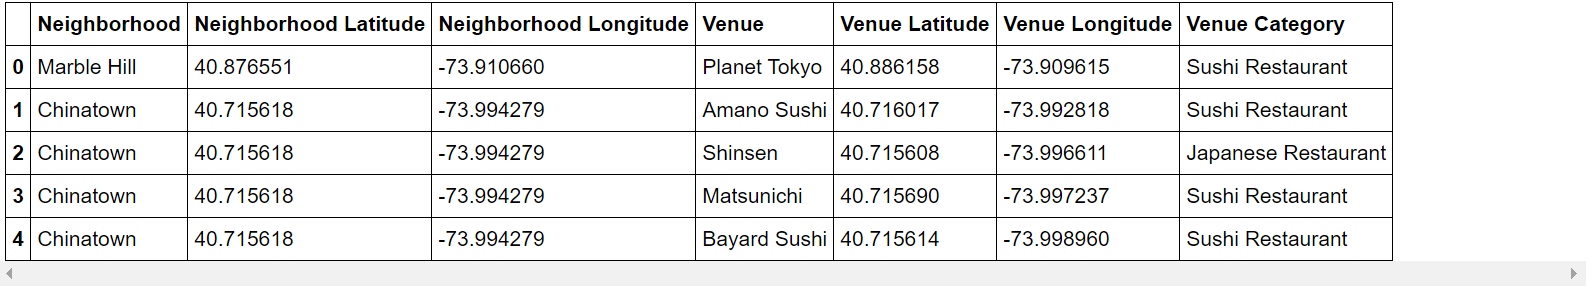

In [15]:
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
newyork_venues_sushi = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d1d2941735')
newyork_venues_sushi.head()

In [16]:
newyork_venues_sushi.shape


(1086, 7)


In [17]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [18]:
map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(newyork_venues_sushi, 'red', map_newyork_sushi)

map_newyork_sushi

In [19]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

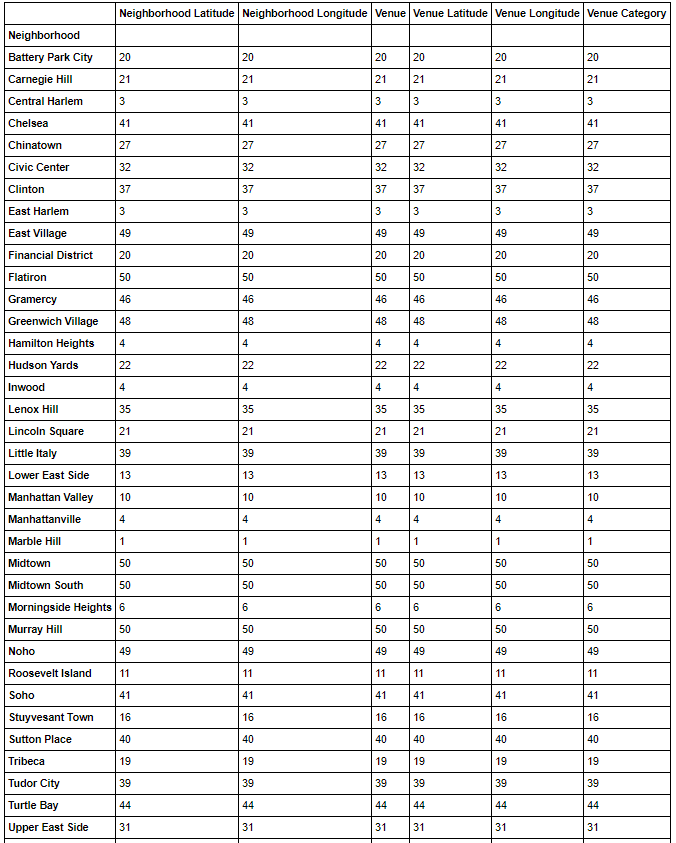

In [20]:
manhattan_grouped = newyork_venues_sushi.groupby('Neighborhood').count()
manhattan_grouped

3. Analyze Each Neighborhood

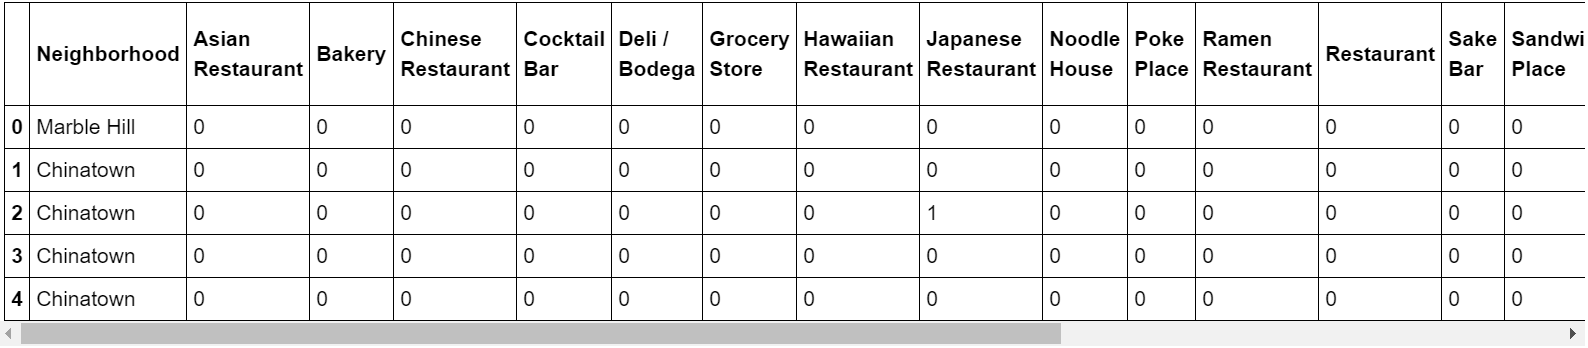

In [21]:
manhattan_onehot = pd.get_dummies(newyork_venues_sushi[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = newyork_venues_sushi['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

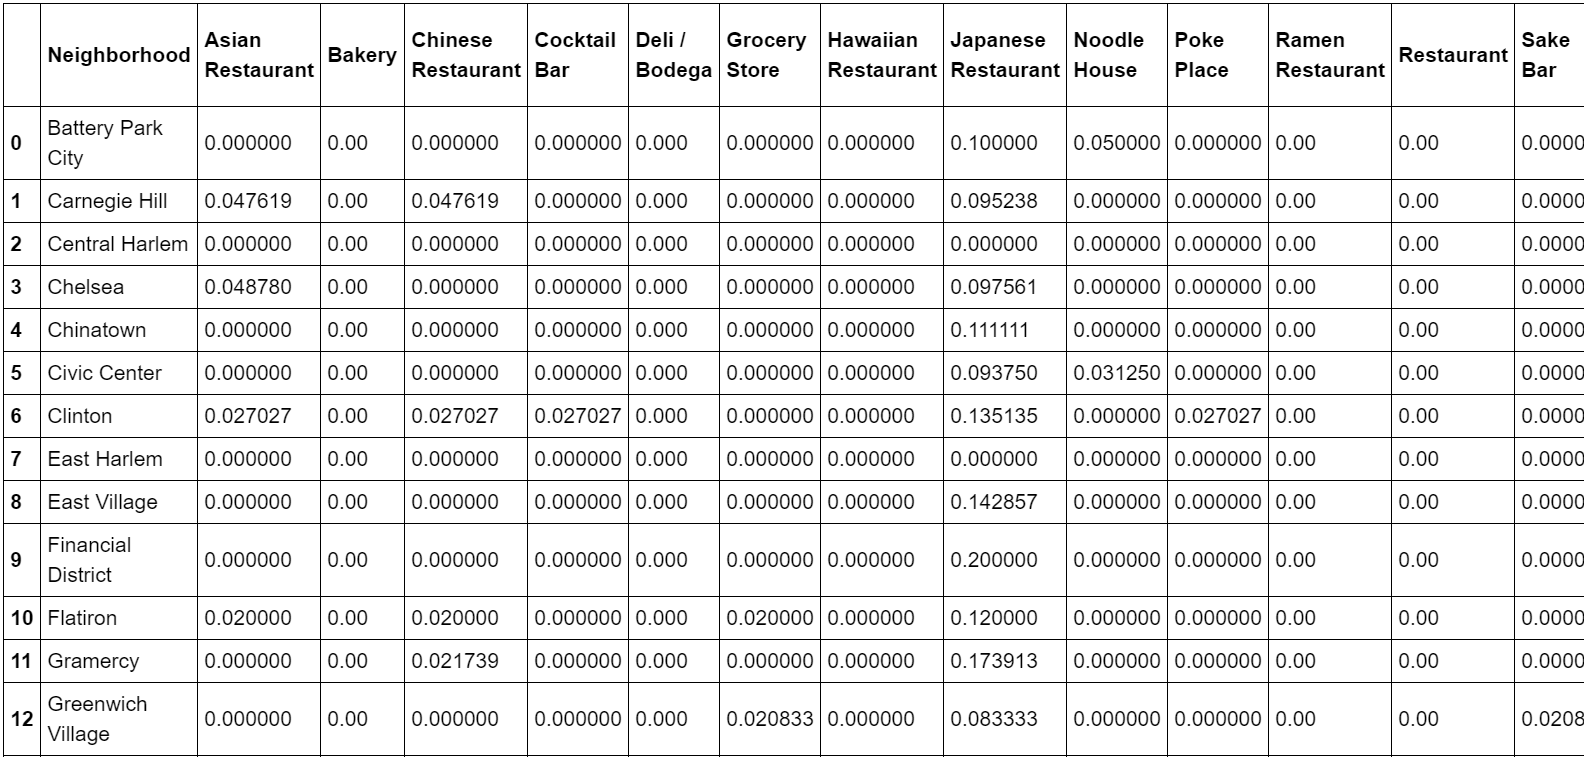

In [22]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head(13)


In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

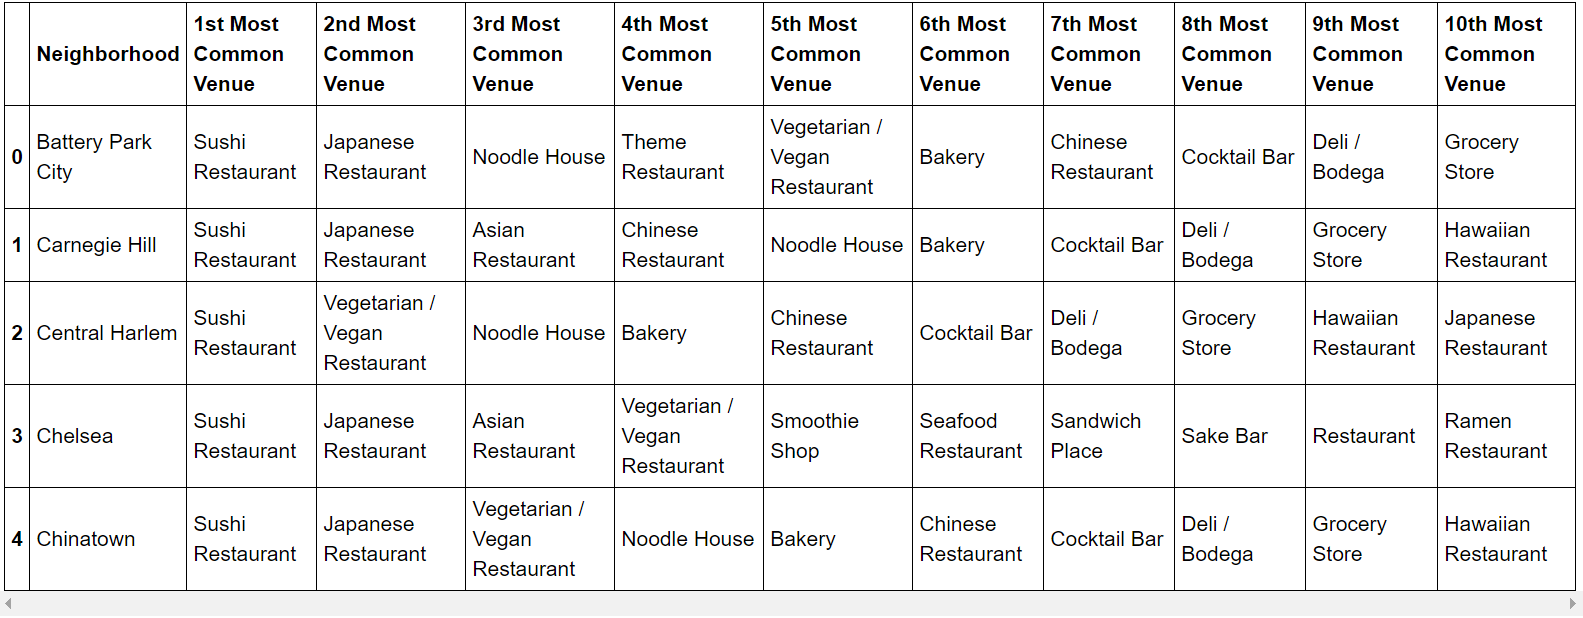

In [25]:

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


Cluster Neighborhoods

In [26]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 2, 1, 1, 2, 0, 1, 2], dtype=int32)


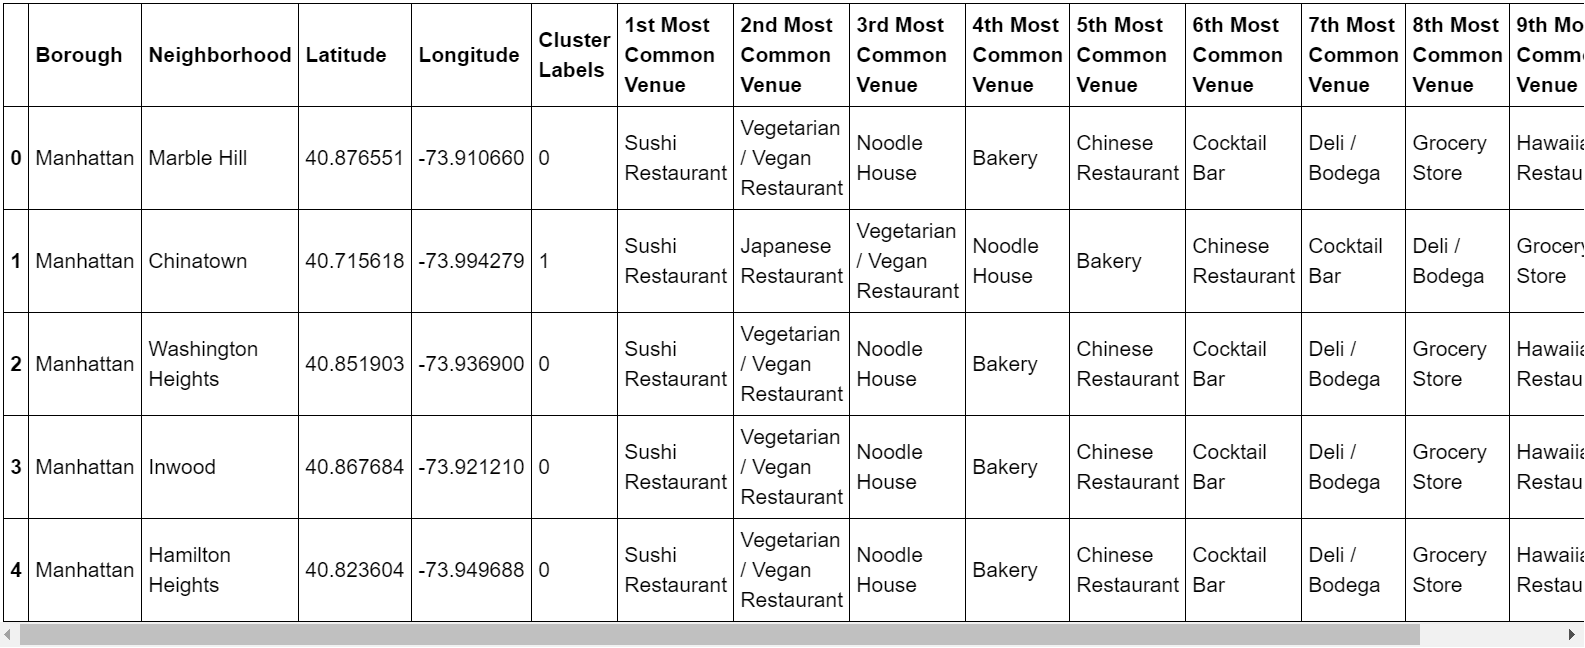

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

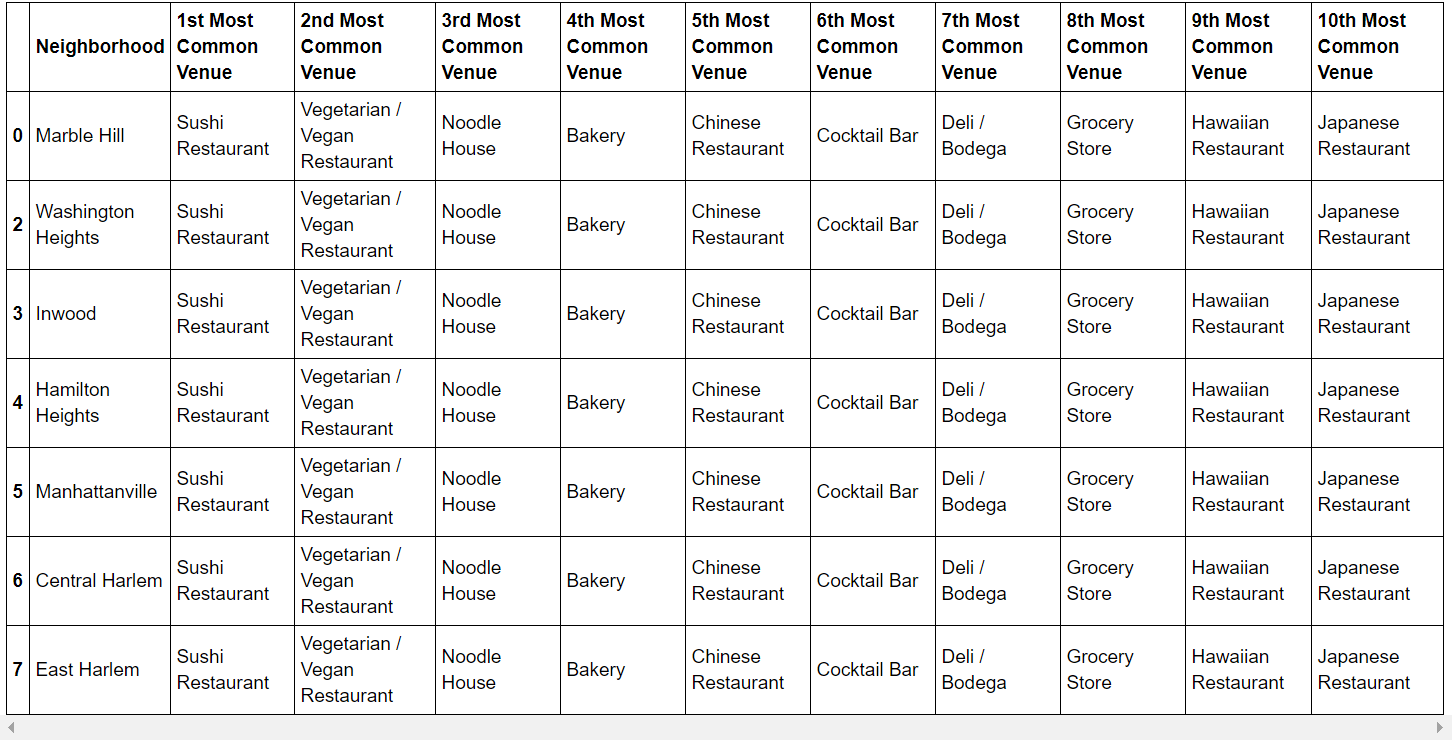

In [29]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


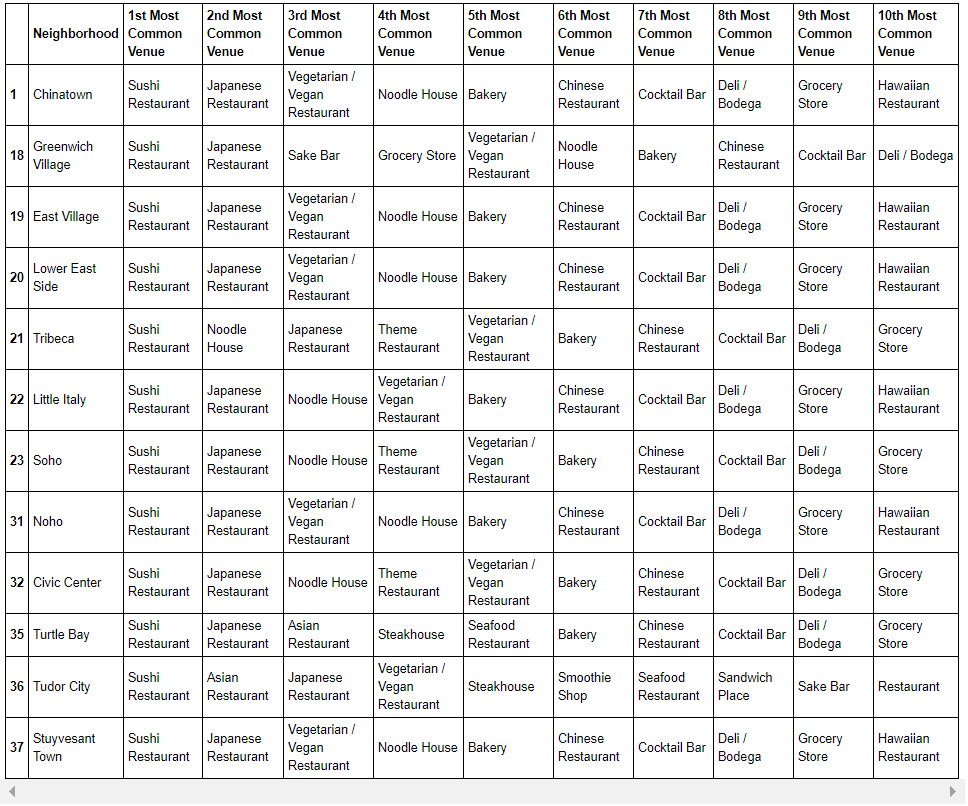

In [30]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


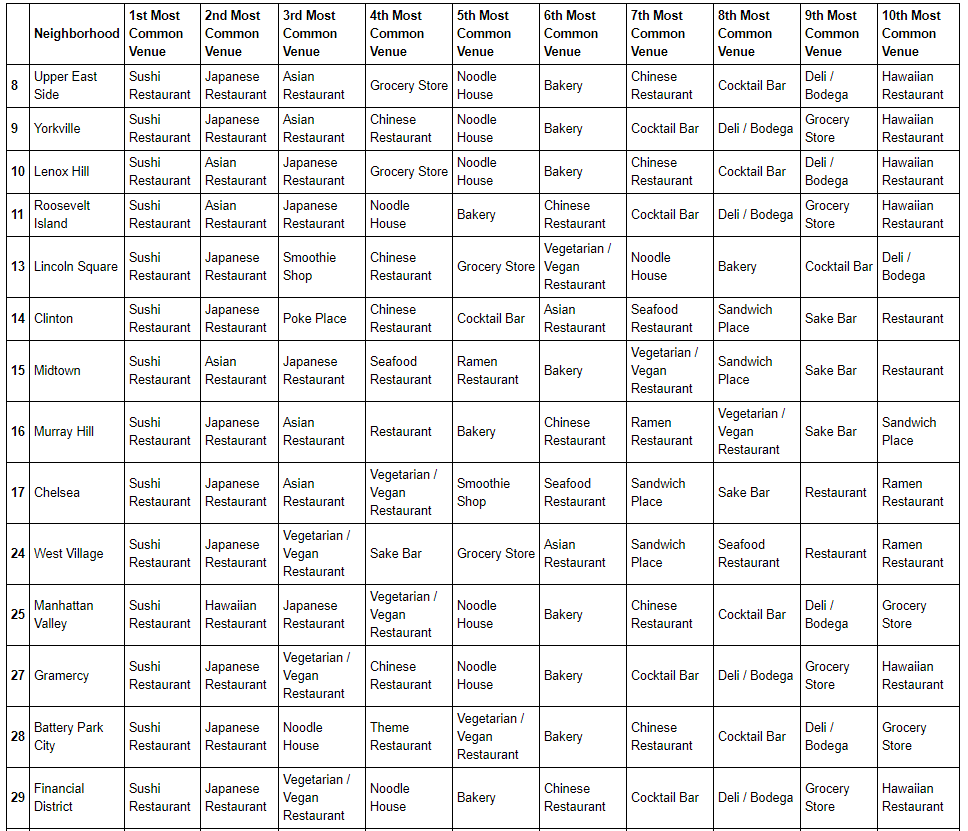

In [31]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


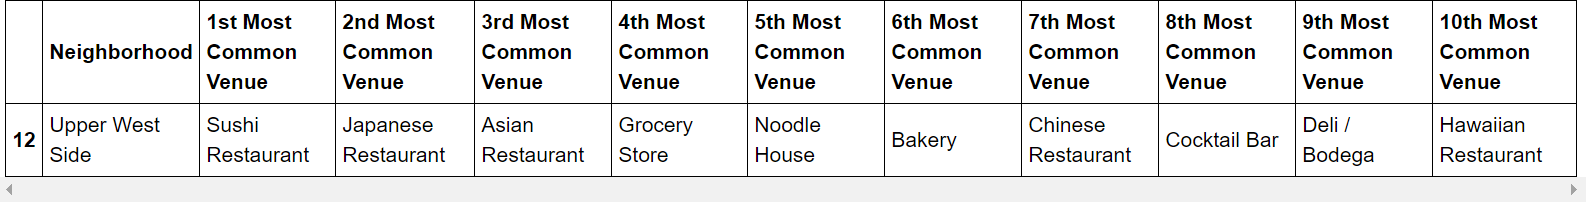

In [32]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]


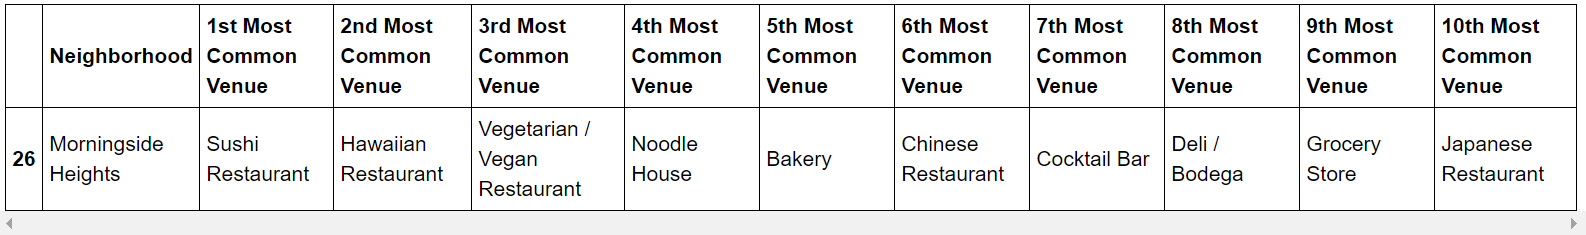

In [33]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
